## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [26]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras import optimizers, metrics
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import load_model
from keras import optimizers, metrics
from keras.layers import Dense
from keras.models import load_model
from helpers import PlotROCCurve

from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,90728,12155170,NaN,30810678,2157-10-18 07:58:00,2157-10-18 13:35:00,M,WHITE,AMBULANCE,HOME,47.0,2157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2157,47.0,False,0 days 05:37:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,5.62,NaN,NaN,36.555556,87.0,18.0,97.0,119.0,83.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,94.0,18.0,97.0,139.0,93.0,5.0,2.0,12.0,95.000000,0,0,2,0,0,1
1,84908,12020576,NaN,33335111,2149-11-30 19:15:00,2149-11-30 21:49:00,M,OTHER,WALK IN,HOME,44.0,2149.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2149,44.0,False,0 days 02:34:00,NaN,NaN,False,False,False,0,0,0,2149-12-19 19:58:00,18 days 22:09:00,False,0,0,0,0,0,0,2.57,NaN,18.92,36.555556,64.0,18.0,100.0,151.0,93.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.111111,84.0,13.0,100.0,127.0,70.0,0.0,4.0,0.0,112.333333,0,0,4,0,0,1
2,375094,18818507,NaN,39510756,2205-01-05 11:34:00,2205-01-05 16:54:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ELOPED,44.0,2198.0,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2205,51.0,False,0 days 05:20:00,NaN,NaN,False,False,False,0,0,2,2205-09-24 07:27:00,261 days 14:33:00,False,0,0,1,0,0,0,5.33,NaN,261.61,37.111111,74.0,18.0,98.0,178.0,103.0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,36.666667,75.0,16.0,99.0,146.0,100.0,0.0,4.0,6.0,128.000000,1,0,4,0,0,1
3,211628,14995724,26467950.0,34723899,2123-12-06 11:51:00,2123-12-06 17:56:00,M,WHITE,AMBULANCE,ADMITTED,91.0,2123.0,2128-11-22,2123-12-06 16:00:00,2123-12-09 18:01:00,NaN,WHITE,2123-12-06 11:51:00,2123-12-06 17:56:00,Medicare,2123,91.0,False,0 days 06:05:00,NaN,NaN,False,True,False,0,0,0,2126-03-14 12:24:00,828 days 18:28:00,False,0,0,0,0,0,0,6.08,NaN,828.77,36.277778,66.0,14.0,96.0,129.0,53.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,60.0,18.0,94.0,122.0,66.0,0.0,2.0,10.0,78.333333,4,9,8,0,0,0
4,101301,12406461,23331394.0,36115826,2131-01-18 21:17:00,2131-01-19 03:20:00,F,WHITE,WALK IN,ADMITTED,23.0,2125.0,NaN,2131-01-19 01:40:00,2131-02-13 18:30:00,NaN,WHITE,2131-01-18 21:17:00,2131-01-19 03:20:00,Medicare,2131,29.0,False,0 days 06:03:00,NaN,NaN,False,True,False,1,3,12,2131-03-02 20:56:00,42 days 17:36:00,False,1,3,10,0,0,0,6.05,NaN,42.73,38.166667,133.0,18.0,100.0,136.0,89.0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,37.111111,86.0,18.0,100.0,127.0,79.0,0.0,2.0,13.0,104.666667,1,4,2,4,4,4


In [12]:
df_train["outcome"].head()

KeyError: 'outcome'

### 1. Task-specific filter: No task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 334420 , testing size = 83605


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [13]:
y_train.head()

0    False
1    False
2    False
3     True
4     True
Name: outcome_hospitalization, dtype: bool

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8972139173649365 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

In [14]:
y_train.value_counts()

outcome_hospitalization
False    176269
True     158151
Name: count, dtype: int64

Logistic Regression:


/home/olavo-dalberto/gpt_ed_assistant/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 8.946414709091187 seconds
AUC: 0.805232931407965
AUPRC: 0.7671005764631651
Sensitivity: 0.7548426150121066
Specificity: 0.7129239939031327
Score thresold: 0.4365935490818854
2.5 97.5


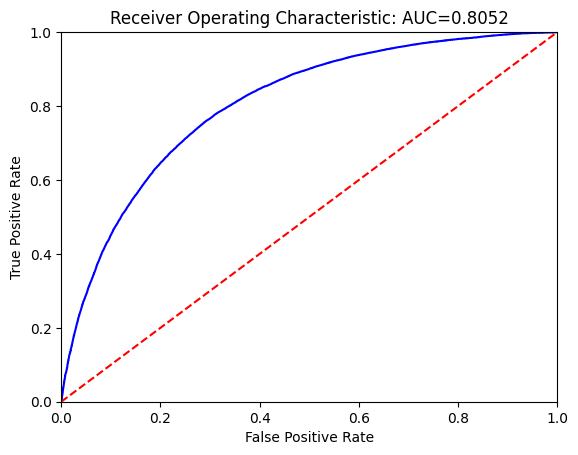

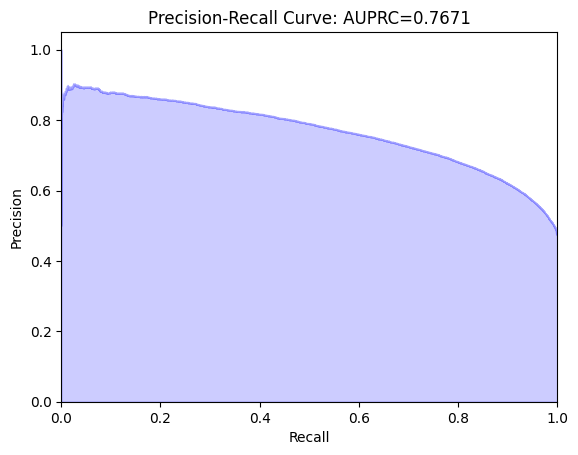

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 58.86539626121521 seconds
AUC: 0.8186111317368394
AUPRC: 0.7852771378272476
Sensitivity: 0.7568603712671509
Specificity: 0.7276201742612098
Score thresold: 0.4864444444444444
2.5 97.5


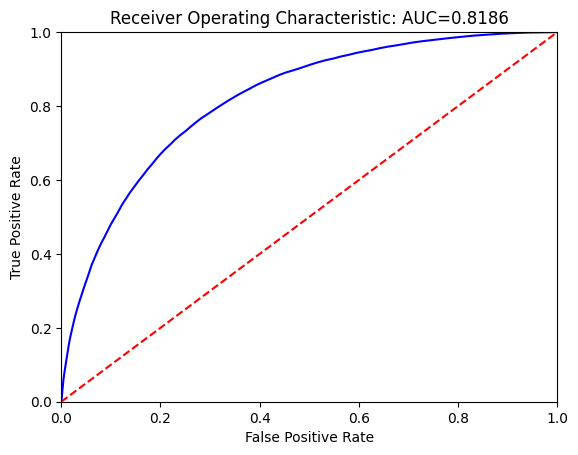

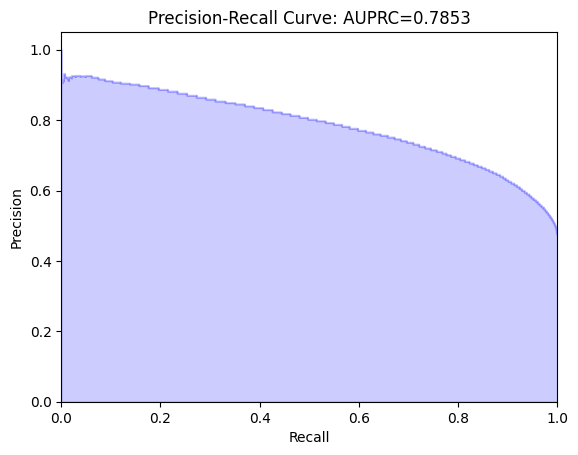

[0.1269717  0.01287127 0.00774949 0.01150576 0.02225346 0.00593039
 0.01479605 0.026903   0.00074059 0.00188665 0.00538353 0.07805504
 0.08533282 0.04018058 0.04232435 0.08698597 0.08254188 0.04777831
 0.11210409 0.00694249 0.00889325 0.00511579 0.00052202 0.00424721
 0.00279628 0.0038554  0.00421395 0.00344978 0.00412876 0.00344715
 0.00547499 0.00283584 0.00303017 0.00140519 0.00621392 0.00216508
 0.00152288 0.00378268 0.0058562  0.00346972 0.00124656 0.00553542
 0.00447091 0.00142471 0.00194697 0.00104943 0.00846853 0.00281406
 0.00245006 0.00541909 0.01021427 0.00455732 0.00427287 0.0009002
 0.00392461 0.0047874  0.00355221 0.01317001 0.00116201 0.00339781
 0.00485694 0.00402917 0.00278305 0.00790273]


In [15]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 56.10325217247009 seconds
AUC: 0.8186500715016581
AUPRC: 0.7921709062646642
Sensitivity: 0.754161622276029
Specificity: 0.7276429237664082
Score thresold: 0.4759241352590424
2.5 97.5


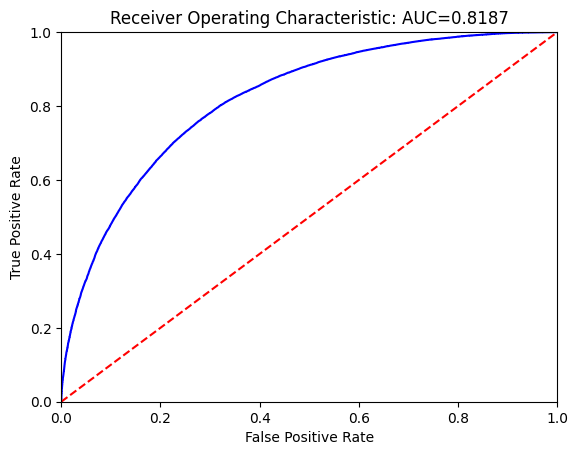

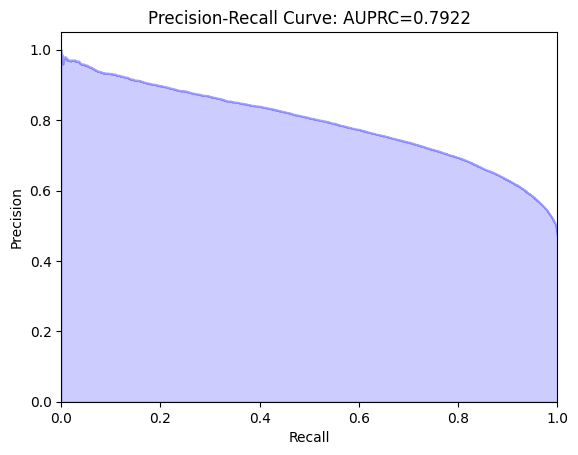

In [16]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [30]:
import keras
from keras.saving import register_keras_serializable

@register_keras_serializable(package="custom", name="MLP")
class MLP(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)   # passa name, trainable, dtype...
        self.dense_1 = keras.layers.Dense(128, activation='relu')
        self.dense_2 = keras.layers.Dense(64, activation='relu')
        self.classifier = keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        # aqui você pode adicionar hiperparâmetros próprios, se tivesse
        return config

In [31]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', metrics.AUC(name='AUC'), metrics.AUC(name='auprc', curve='PR'), 
                       metrics.TruePositives(), metrics.TrueNegatives(), metrics.Precision(), metrics.Recall()])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp.keras')

Epoch 1/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.7724 - accuracy: 0.7070 - auprc: 0.7299 - loss: 0.5983 - precision_4: 0.7006 - recall_4: 0.6642 - true_negatives_4: 131391.0000 - true_positives_4: 105040.0000
Epoch 2/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.8022 - accuracy: 0.7273 - auprc: 0.7729 - loss: 0.5409 - precision_4: 0.7172 - recall_4: 0.6990 - true_negatives_4: 132679.0000 - true_positives_4: 110547.0000
Epoch 3/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.8055 - accuracy: 0.7305 - auprc: 0.7765 - loss: 0.5364 - precision_4: 0.7182 - recall_4: 0.7078 - true_negatives_4: 132343.0000 - true_positives_4: 111938.0000
Epoch 4/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.8094 - accuracy: 0.7332 - auprc: 0.7804 - loss: 0.5313 - precision_4: 0.7195 - recall_4: 0.7142 - true_negatives_4: 132235.0000 - true_positives_4: 112957.0000
Epoch 5/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.8115 - accuracy: 0.7350 - auprc: 0.7825 - los

MLP:
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
AUC: 0.8222300358999678
AUPRC: 0.7956815847470299
Sensitivity: 0.7551200564971752
Specificity: 0.734149282253111
Score thresold: 0.560907
2.5 97.5


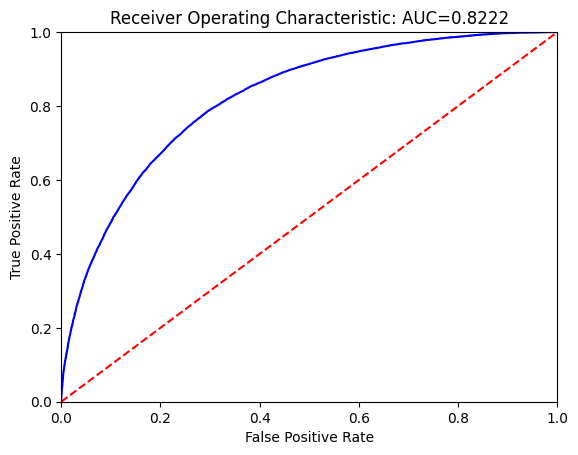

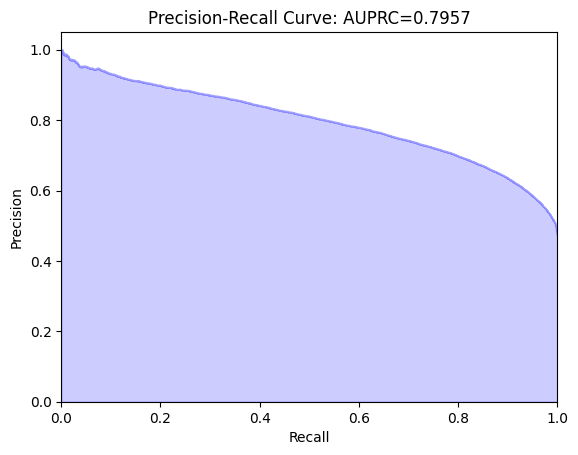

In [32]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp.keras')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [33]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7102458587821618
AUPRC: 0.6309947465538657
Sensitivity: 0.5828541162227603
Specificity: 0.7818777441590645
Score thresold: -2.0
2.5 97.5


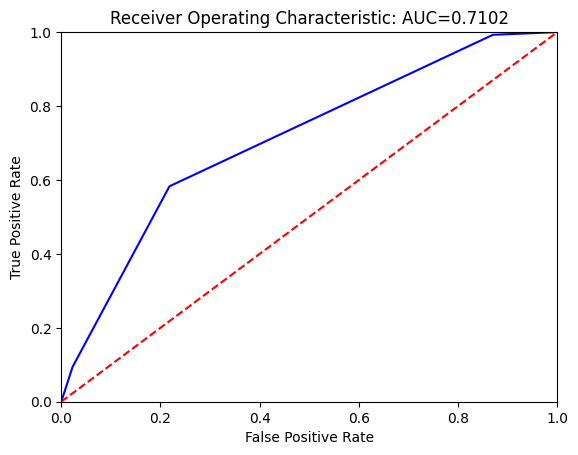

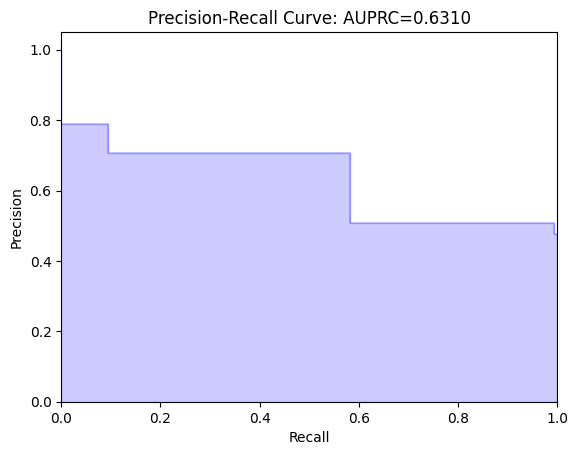

In [34]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

score_NEWS
AUC: 0.582425578271215
AUPRC: 0.5580058453993274
Sensitivity: 0.5673426150121066
Specificity: 0.541779466296608
Score thresold: 1.0
2.5 97.5


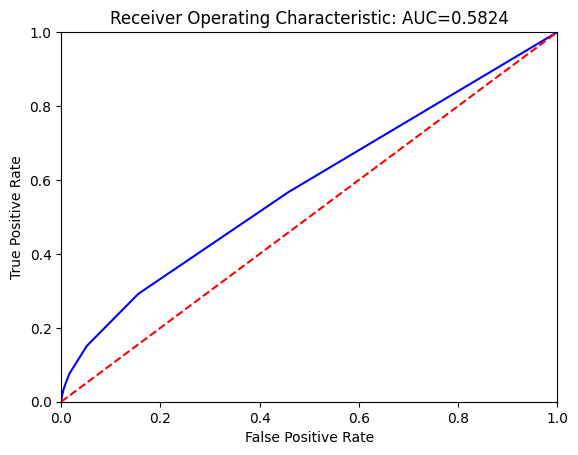

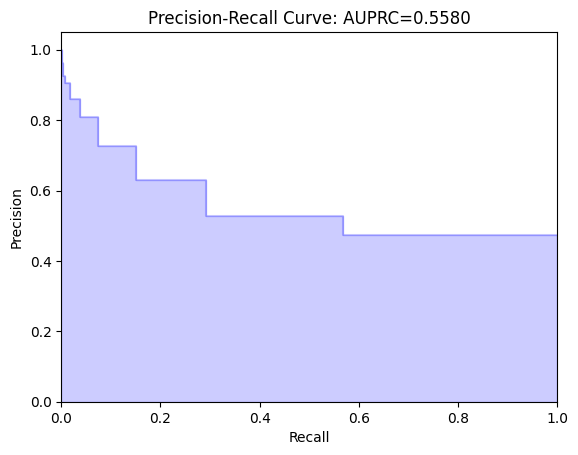

In [36]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5643522789661105
AUPRC: 0.5407322747843148
Sensitivity: 0.5199757869249395
Specificity: 0.5641649794116979
Score thresold: 1.0
2.5 97.5


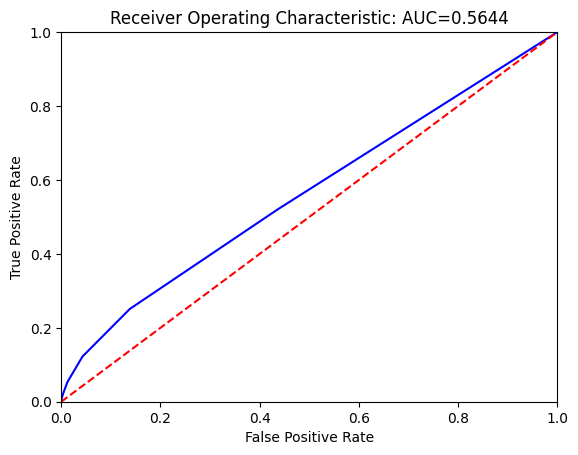

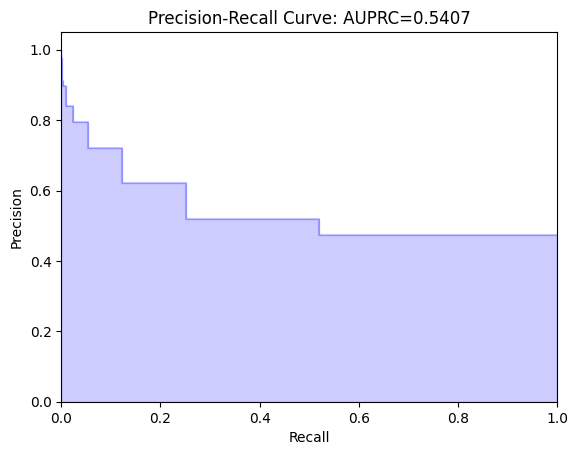

In [37]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6712545277299118
AUPRC: 0.6098651467928164
Sensitivity: 0.7166817998385795
Specificity: 0.556111654571513
Score thresold: 3.0
2.5 97.5


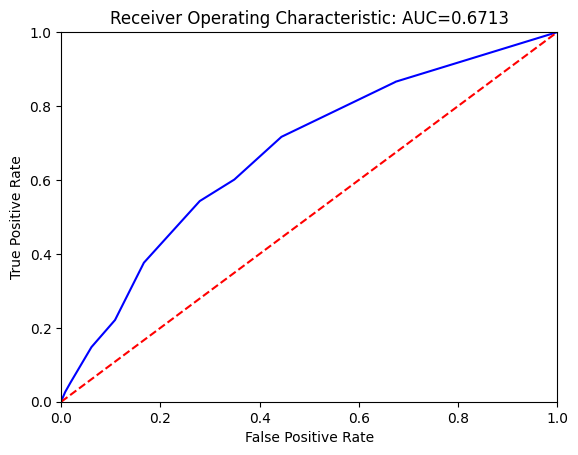

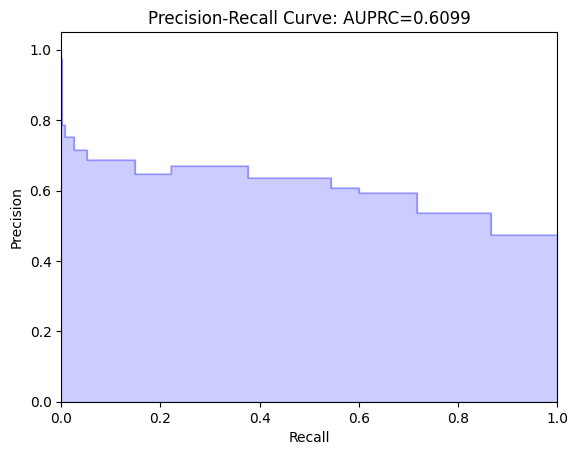

In [38]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5614306599327581
AUPRC: 0.5256156404482384
Sensitivity: 0.30130145278450365
Specificity: 0.8127715722183042
Score thresold: 2.0
2.5 97.5


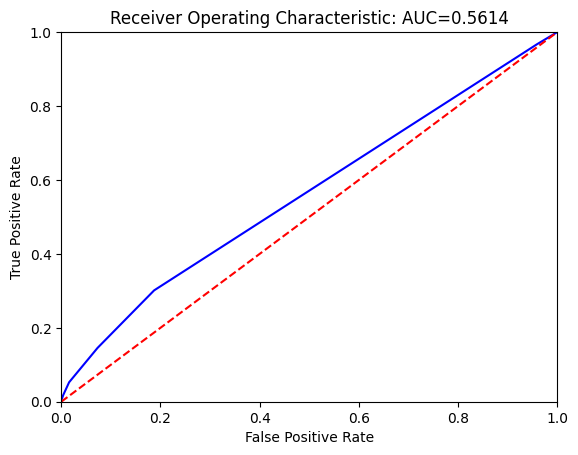

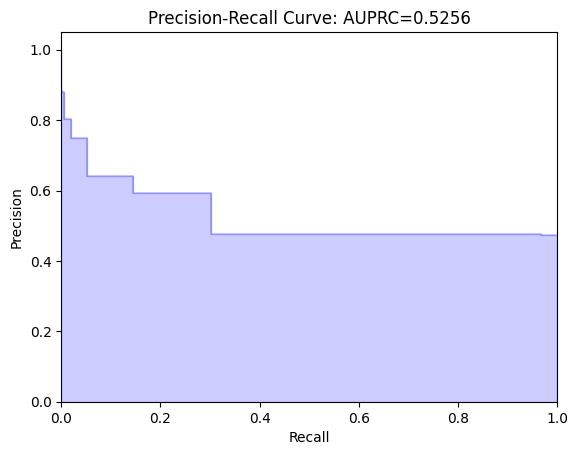

In [39]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6743324282555612
AUPRC: 0.618467362754646
Sensitivity: 0.7036420500403551
Specificity: 0.582501080601497
Score thresold: 4.0
2.5 97.5


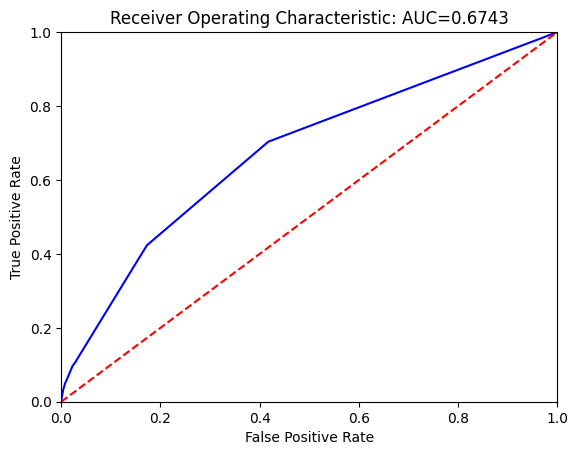

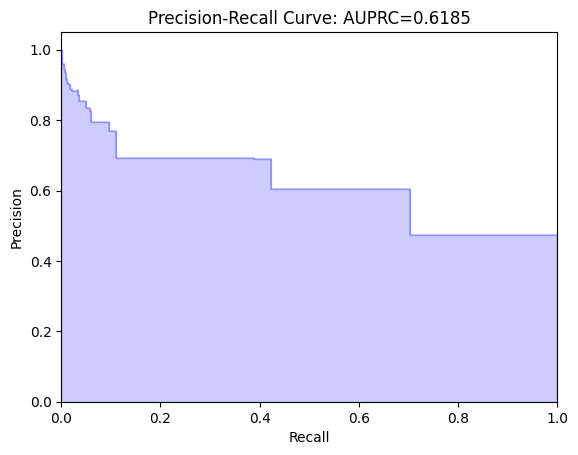

In [40]:
get_score_performance("score_CART", random_seed=random_seed)

In [42]:
import keras
from keras import optimizers, metrics, layers, Model
from embedding import *

In [43]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


FileNotFoundError: [Errno 2] Arquivo ou diretório inexistente: '/home/olavo-dalberto/gpt_ed_assistant/data/raw/processed/icd_list_dataset_v10.csv'

Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_3 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

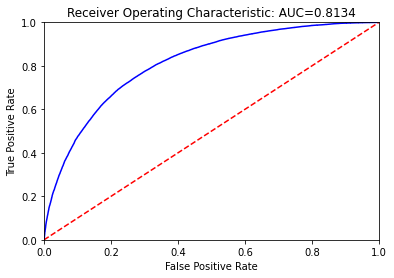

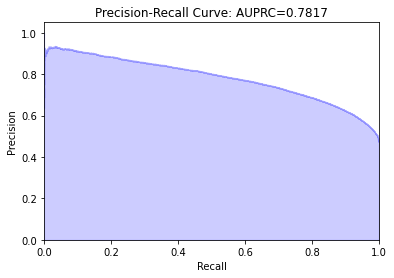

In [28]:
# To train from scratch, set load_model to None
load_model = None#"embedding_hospitalization_"+version 
save_model = "embedding_hospitalization_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [44]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.437,0.805 (0.803-0.808),0.767 (0.763-0.77),0.755 (0.737-0.757),0.713 (0.709-0.729),8.946
1,RF,0.486,0.819 (0.817-0.82),0.785 (0.782-0.788),0.757 (0.739-0.763),0.728 (0.721-0.745),58.865
2,GB,0.476,0.819 (0.817-0.82),0.792 (0.789-0.794),0.754 (0.742-0.763),0.728 (0.722-0.74),56.103
3,MLP,0.561,0.822 (0.821-0.824),0.796 (0.793-0.799),0.755 (0.746-0.766),0.734 (0.726-0.744),47.180
4,esi,-2.000,0.71 (0.708-0.712),0.631 (0.628-0.633),0.583 (0.579-0.586),0.782 (0.778-0.786),0.000
5,score_NEWS,1.000,0.582 (0.58-0.586),0.558 (0.554-0.562),0.567 (0.564-0.571),0.542 (0.538-0.546),0.000
6,score_NEWS2,1.000,0.564 (0.562-0.568),0.541 (0.536-0.545),0.52 (0.517-0.525),0.564 (0.561-0.567),0.000
7,score_REMS,3.000,0.671 (0.669-0.675),0.61 (0.605-0.614),0.717 (0.654-0.719),0.556 (0.552-0.608),0.000
8,score_MEWS,2.000,0.561 (0.559-0.564),0.526 (0.521-0.529),0.301 (0.298-0.305),0.813 (0.809-0.817),0.000
9,score_CART,4.000,0.674 (0.672-0.678),0.618 (0.615-0.622),0.704 (0.7-0.707),0.583 (0.579-0.587),0.000


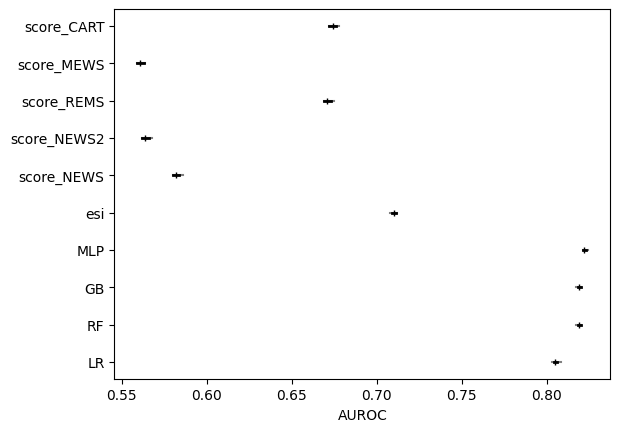

In [46]:
from helpers import plot_confidence_interval
import os

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

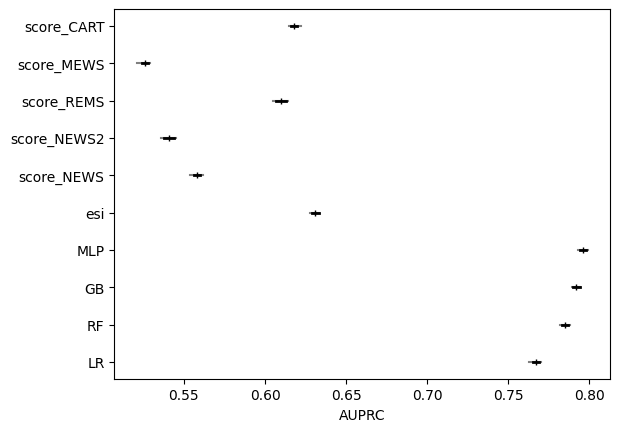

In [47]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [48]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.126972
18,triage_acuity,0.112104
15,triage_sbp,0.086986
12,triage_heartrate,0.085333
16,triage_dbp,0.082542
11,triage_temperature,0.078055
17,triage_pain,0.047778
14,triage_o2sat,0.042324
13,triage_resprate,0.040181
7,n_hosp_365d,0.026903
